Library Imports

Goal: Create a data pipeline for studying the subtitles of TV shows.

In [15]:
suppressPackageStartupMessages(library(srt))
suppressPackageStartupMessages(library(tm))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(textstem))
suppressPackageStartupMessages(library(tidytext))
suppressPackageStartupMessages(library(zoo))
suppressPackageStartupMessages(library(dplyr))

Get the names of our files for reading.

In [16]:
filenames <- list.files(path="./GilmoreGirls",pattern="*.srt")
# head(filenames)

Create Meta-table to aggregate data from all the episodes 

In [17]:
meta <- data.frame(
    episodeName=character(),
    fullSubtitles=character(),
    subtitleCount=numeric(),
    wordCount=numeric(),
    runTime=numeric(),
    speakingTime=numeric(),

    averageWPM=numeric(),
    stdWPM=numeric(),

    averageSubtitleLength=numeric(),
    stdSubtitleLength=numeric(),

    averageSubtitleWPM = numeric(),
    stdSubtitleWPM = numeric(),

    averageduration = numeric(),
    stdDuration = numeric(),

    stringsAsFactors = FALSE
)

Now the main function to create a file for each episode, as well as adding rows to our meta table

In [18]:
readFileByIndex <- function(i){

    # some variables parsed from filenames
    episodeCode <- str_extract(filenames[i],"[0-9]+.*?[0-9]+")
    title <- str_extract(filenames[i],"(?<=[0-9]\\s-\\s).*(?=\\.en)")
    season <- str_extract(filenames[i],"(?<=(\\s-\\s)).*?(?=x)")
    episode <- str_extract(filenames[i],"(?<=([0-9]x)).*?(?=\\s)")
    prefix <- paste(getwd(),"/GilmoreGirls/",sep="")
     

    df <- read_srt(paste(prefix,filenames[i],sep=""))
    df <- df[-nrow(df),] #drop last row because it's credit information

    # some functions to clean up
    dropPunct <- (function (x) gsub('[[:punct:]]+','',x))
    dropNL <- (function(x) gsub("\n", " ", x))

    # create new csv for
    df <- df %>% 
        mutate(subtitle = sapply(subtitle,tolower)) %>%

        # cleanWords will clean up punctuation 
        mutate(cleanWords = sapply(subtitle,dropNL)) %>%
        mutate(cleanWords = sapply(cleanWords,removePunctuation)) %>%

        mutate(wordCount = sapply(strsplit(cleanWords,"\\s+"),length)) %>%
        mutate(cumWordCount = cumsum(wordCount)) %>%

        # deepCleanWords, for advanced processing
        # mutate(deepCleanWords = sapply(cleanWords,removeWords,stopwords('english'))) %>%
        # mutate(deepCleanWords = sapply(deepCleanWords, textstem::lemmatize_strings))
        
        mutate(minute = (1+floor(end / 60))) %>%
        mutate(duration = (end-start)/ 60) %>%
        mutate(subtitleWPM = wordCount/duration) %>% # All words / total time
        mutate(cumTimeSpeaking = cumsum(duration)) %>%
        mutate(rollingWPM = rollmean(cumWordCount/(end/60),k=5,fill=0)) 
        # mutate(rollingWPMSpeaking = rollmean(cumWordCount/cumTimeSpeaking,k=10,fill=0)) # All words / time talking

    # assemble row for Meta table
    temp <- data.frame(
        episodeName     = paste(episodeCode,' - ',title,collapse = ""),
        subtitleCount   = nrow(df),
        fullSubtitles   = paste(df$subtitle,collapse = ' '),
        totalWordCount   = sum(sapply(strsplit(paste(df$subtitle),"\\s+"), length)),
        runTime         = df$end[length(df$end)],
        speakingTime    = df$cumTimeSpeaking[length(df$cumTimeSpeaking)],

        averageWPM      = mean(df$rollingWPM, na.rm = TRUE),
        stdWPM          = sd(df$rollingWPM, na.rm = TRUE),

        averageSubtitleLength = mean(df$wordCount, na.rm = TRUE),
        stdSubtitleLength = sd(df$wordCount, na.rm = TRUE),

        averageSubtitleWPM = mean(df$subtitleWPM, na.rm = TRUE),
        stdSubtitleWPM  = sd(df$subtitleWPM, na.rm = TRUE),

        averageDuration = mean(df$duration, na.rm = TRUE),
        stdDuration     = mean(df$duration, na.rm = TRUE)
    )

    write.csv(df,paste('episode_analysis/',episodeCode,' - ',title,collapse=""))

    meta <<- rbind(meta,temp)


    return(df)
}

Check data, and save a copy to double check it in a csv reader.

In [19]:
for (i in 1:length(filenames)){
    testdf <- readFileByIndex(i)
    # if (i %% 10){
    #     print(tail(testdf,1))
    # }
}

metaSkipSubs <- meta[,!(names(meta) %in% "fullSubtitles")]
head(metaSkipSubs)

write.csv(meta,paste('meta.csv',collapse=""))



,episodeName,subtitleCount,totalWordCount,runTime,speakingTime,averageWPM,stdWPM,averageSubtitleLength,stdSubtitleLength,averageSubtitleWPM,stdSubtitleWPM,averageDuration,stdDuration
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1x01 - Pilot,683,5443,2597.533,28.70083,1.844556,0.2964811,7.734993,3.549200,178.8581,54.85999,0.04202172,0.04202172
2,1x02 - The Lorelais' First Day at Chilton,754,5930,2535.550,29.82103,2.028252,0.3194839,7.648541,3.625911,186.7461,57.94773,0.03955044,0.03955044
3,1x03 - Kill Me Now,757,6453,2579.825,31.77183,2.542794,0.2545724,8.224571,3.443770,193.1982,55.30976,0.04197072,0.04197072
4,1x04 - The Deer Hunters,785,6446,2623.680,32.20267,2.281355,0.2898894,7.950318,3.438428,190.9469,55.81081,0.04102251,0.04102251
5,1x05 - Cinnamon's Wake,711,5803,2531.652,29.40653,2.184570,0.3066847,7.890295,3.579174,186.0856,56.53549,0.04135940,0.04135940
6,1x06 - Rory's Birthday Parties,751,6335,2605.976,31.36952,2.464732,0.2240742,8.166445,3.473748,192.4906,54.60029,0.04177033,0.04177033


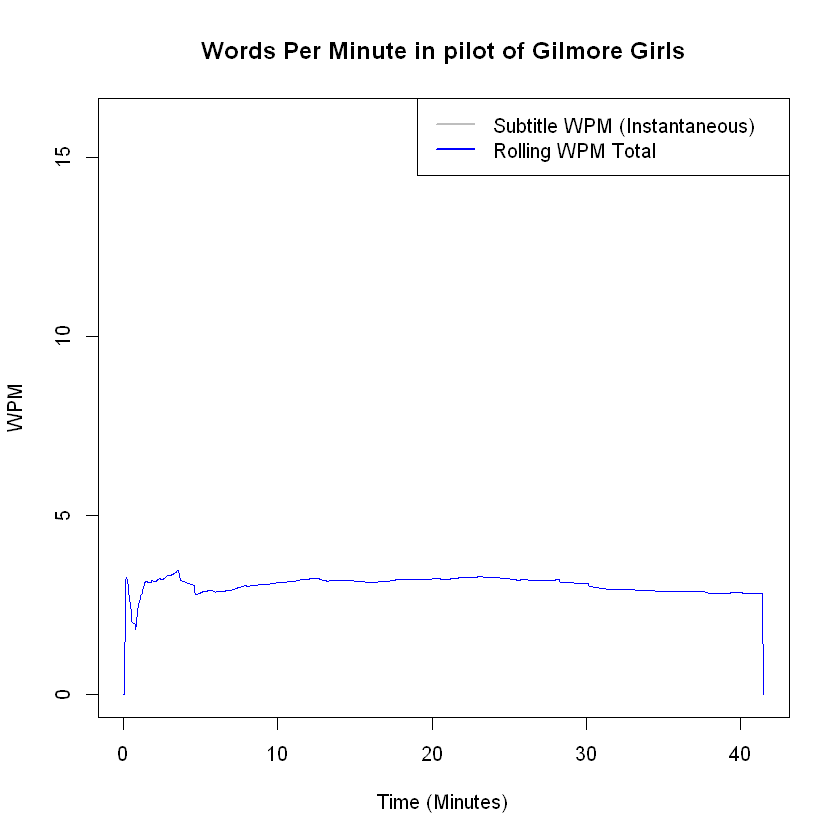

In [20]:
# paste(testdf$cleanWords,collapse = " ")

plot(testdf$start/60,testdf$subtitleWPM, xlab="Time (Minutes)",ylab="WPM", main='Words Per Minute in pilot of Gilmore Girls',
 col='gray',ylim=c(0,16))

       lines(testdf$start/60,testdf$rollingWPM,col="blue")
       # lines(testdf$start/60,testdf$rollingWPMSpeaking,col="red")
       legend("topright", legend = c("Subtitle WPM (Instantaneous)", "Rolling WPM Total"),
              col = c("gray", "blue"), lwd = 2)

In [21]:
head(testdf[testdf$subtitleWPM >5,])

n,start,end,subtitle,cleanWords,wordCount,cumWordCount,minute,duration,subtitleWPM,cumTimeSpeaking,rollingWPM
<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.455,2.222,previously on gilmore girls...,previously on gilmore girls,4,4,1,0.02945000,135.82343,0.02945000,0.000000
2,2.223,4.423,i didn't get the internship at the new york times.,i didnt get the internship at the new york times,10,14,1,0.03666667,272.72727,0.06611667,0.000000
3,4.458,5.078,what?,what,1,15,1,0.01033333,96.77419,0.07645000,2.909732
4,5.113,7.373,- we heard the song. - it gave me goose bumps.,we heard the song it gave me goose bumps,10,25,1,0.03766667,265.48673,0.11411667,3.153926
5,7.408,9.881,the way you locked eyes with him.,the way you locked eyes with him,7,32,1,0.04121667,169.83421,0.15533333,3.184661
6,9.916,12.578,"no, no, no. it's just karaoke.",no no no its just karaoke,6,38,1,0.04436667,135.23666,0.19970000,3.259435
